In [2]:
import os
import re


import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [3]:
# Define colors for modes
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import seaborn as sns

MODE_COLORS = {"hard": "blue", "soft": "red", "Weady et al.": "black"}
LINE_STYLES = {"$\\lambda = 10^{-2}$": "solid",
               "$\\lambda = 10^{-3}$": "dashed", "$\\lambda = 10^{-4}$": "dotted"}

In [4]:
from load_combined import load_combined

source_folders = [
    "../data/strong_scaling/",
 
]

# find recursive subfolders within source_folders
sim_dirs = []
for folder in source_folders:
    for root, dirs, files in os.walk(folder):
        # skip if /data as last part of path
        if "logs" in root or "data" in root.split(os.sep)[-1]:
            continue

        if any(f.endswith(".pvtu") for f in os.listdir(root)):
            sim_dirs.append(os.path.join(root))

particles_dict, sim_dict, params_dict = load_combined(sim_dirs, offset=0)

loading ../data/strong_scaling/1760916059116.569/output_hard/112ranks/vtk_output_hard
loading ../data/strong_scaling/1760916059116.569/output_soft/112ranks/vtk_output_soft
loading ../data/strong_scaling/1760916059116.569/output_soft/96ranks/vtk_output_soft
loading ../data/strong_scaling/1761245795146.2/output_hard/2ranks/vtk_output_hard
loading ../data/strong_scaling/1761142928038.939/output_hard/48ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/8ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/112ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/48ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/2ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/96ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/4ranks/vtk_output_hard
loading ../data/strong_scaling/1761180588593.814/output_hard/16ranks

In [5]:
# print sizte of particles_dict in MB
print(f"Loaded particles_dict with {particles_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded sim_dict with {sim_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"Loaded params_dict with {params_dict.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loaded particles_dict with 1039.43 MB
Loaded sim_dict with 0.23 MB
Loaded params_dict with 0.01 MB


In [6]:
sim_dict.keys()

Index(['iteration', 'simulation_time_s', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'cpu_time_s', 'mpi_comm_time_s',
       'load_imbalance', 'dt_s', 'x', 'y', 'z', 'rank', 'Mode', 'Sensitivity',
       'sim_dir', 'offset'],
      dtype='object')

In [7]:
particles_dict["sim_dir"]

0          .._data_strong_scaling_1760916059116.569
1          .._data_strong_scaling_1760916059116.569
2          .._data_strong_scaling_1760916059116.569
3          .._data_strong_scaling_1760916059116.569
4          .._data_strong_scaling_1760916059116.569
                             ...                   
2072376    .._data_strong_scaling_1761142936463.112
2072377    .._data_strong_scaling_1761142936463.112
2072378    .._data_strong_scaling_1761142936463.112
2072379    .._data_strong_scaling_1761142936463.112
2072380    .._data_strong_scaling_1761142936463.112
Name: sim_dir, Length: 2072381, dtype: object

In [27]:
particles_dict["total_ranks"] = particles_dict["Sensitivity"].str.extract(
    r"(\d+)ranks")
sim_dict["total_ranks"] = sim_dict["Sensitivity"].str.extract(r"(\d+)ranks")

In [9]:
from scipy.optimize import curve_fit

runtimes = []
for k, g in particles_dict.groupby(["Mode", "total_ranks", "sim_dir", "Sensitivity"]):
    src = g["Sensitivity"].unique()[0]

    sim_data = sim_dict[sim_dict["Sensitivity"] == src]

    final_time = sim_data["cpu_time_s"].max()

    colony_radius = sim_data["colony_radius"].max()
    if colony_radius < 100:
        continue

    runtimes.append(pd.DataFrame({
        "runtime [h]": [final_time / 3600],
        "Mode": [k[0]],
        "total_ranks": [int(k[1])],
        "sim_dir": [k[2]],
        "colony_radius": [colony_radius],
    }))
runtimes = pd.concat(runtimes, ignore_index=True)


# add accidentally removed data manually back! Data comes from old figures presented in the paper
runtimes = pd.concat([runtimes, pd.DataFrame({
    "runtime [h]": [19.2],
    "Mode": ["hard"],
    "total_ranks": [1],
    "sim_dir": [".._data_strong_scaling_1761142936463.112"],
    "colony_radius": [100.0],
})], ignore_index=True)

runtimes = pd.concat([runtimes, pd.DataFrame({
    "runtime [h]": [23.0],
    "Mode": ["soft"],
    "total_ranks": [1],
    "sim_dir": [".._data_strong_scaling_1761142936463.112"],
    "colony_radius": [100.0],
})], ignore_index=True)

runtimes = pd.concat([runtimes, pd.DataFrame({
    "runtime [h]": [9.0],
    "Mode": ["hard"],
    "total_ranks": [2],
    "sim_dir": [".._data_strong_scaling_1761142936463.112"],
    "colony_radius": [100.0],
})], ignore_index=True)

runtimes["sim_dir"].unique()

array(['.._data_strong_scaling_1760916059116.569',
       '.._data_strong_scaling_1761180588593.814',
       '.._data_strong_scaling_1761142928038.939',
       '.._data_strong_scaling_1761142936463.112'], dtype=object)

In [10]:
def amdahl(N, p):
    return 1 / ((1 - p) + p / N)


def compute_speedup(group):

    if group[group["total_ranks"] == 1].empty:
        print("group has no baseline for speedup calculation")
        return group

    baseline = group[group["total_ranks"] == 1]
    baseline = baseline["runtime [h]"].mean()
    group = group.copy()
    group["speedup"] = baseline / group["runtime [h]"]

    N = group["total_ranks"].values
    S = group["speedup"].values

    # Fit p to all observed speedups
    popt, _ = curve_fit(amdahl, N, S, bounds=(0, 1))
    p_est = popt[0]

    group["amdahl"] = amdahl(N, p_est)
    group["p_est"] = p_est

    group["efficiency"] = group["speedup"] / group["total_ranks"]
    return group


runtimes = runtimes.groupby(["Mode"]).apply(
    compute_speedup).reset_index(drop=True)

runtimes.sort_values(["Mode", "total_ranks"], inplace=True)
runtimes

runtimes

/tmp/ipykernel_2344786/3958430209.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  runtimes = runtimes.groupby(["Mode"]).apply(


,runtime [h],Mode,total_ranks,sim_dir,colony_radius,speedup,amdahl,p_est,efficiency
9,19.200000,hard,1,.._data_strong_scaling_1761142936463.112,100.000,1.000000,1.000000,0.971061,1.000000
10,9.000000,hard,2,.._data_strong_scaling_1761142936463.112,100.000,2.133333,1.943750,0.971061,1.066667
3,4.889333,hard,4,.._data_strong_scaling_1761180588593.814,100.000,3.926916,3.680472,0.971061,0.981729
7,2.556650,hard,8,.._data_strong_scaling_1761180588593.814,100.003,7.509827,6.652400,0.971061,0.938728
2,1.458067,hard,16,.._data_strong_scaling_1761180588593.814,100.004,13.168122,11.156932,0.971061,0.823008
4,0.769689,hard,48,.._data_strong_scaling_1761142928038.939,100.004,24.945144,20.337810,0.971061,0.519690
5,0.781908,hard,48,.._data_strong_scaling_1761180588593.814,100.009,24.555308,20.337810,0.971061,0.511569
6,0.742869,hard,64,.._data_strong_scaling_1761180588593.814,100.004,25.845726,22.669623,0.971061,0.403839
8,0.790222,hard,96,.._data_strong_scaling_1761180588593.814,100.007,24.296963,25.605385,0.971061,0.253093
0,0.836589,hard,112,.._data_strong_scaling_1760916059116.569,100.000,22.950341,26.589200,0.971061,0.204914


In [11]:
for k, g in runtimes.groupby(["total_ranks", "Mode"]):
    print(k, len(g))

(np.int64(1), 'hard') 1
(np.int64(1), 'soft') 1
(np.int64(2), 'hard') 1
(np.int64(2), 'soft') 1
(np.int64(4), 'hard') 1
(np.int64(4), 'soft') 1
(np.int64(8), 'hard') 1
(np.int64(8), 'soft') 1
(np.int64(16), 'hard') 1
(np.int64(16), 'soft') 1
(np.int64(48), 'hard') 2
(np.int64(48), 'soft') 2
(np.int64(64), 'hard') 1
(np.int64(64), 'soft') 2
(np.int64(96), 'hard') 1
(np.int64(96), 'soft') 3
(np.int64(112), 'hard') 2
(np.int64(112), 'soft') 3


In [16]:
def makeplot(data, x, y, xlabel=None, ylabel=None, outname=None, variable="density",
             xscale=None, yscale=None,  hue="Mode",           **kwargs):

    fig, ax = plt.subplots(figsize=(10, 5))
    outname = outname or f"{y}_vs_{x}.png"

    sns.lineplot(data, x=x,                 y=y,
                 hue=hue, marker="o", ax=ax, **kwargs, lw=2, ms=10, palette=MODE_COLORS, style_order=LINE_STYLES.keys())

    if xscale:
        ax.set_xscale(xscale, base=2)
    if yscale:
        ax.set_yscale(yscale, base=2)

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    ax.legend(fontsize=22)

    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")

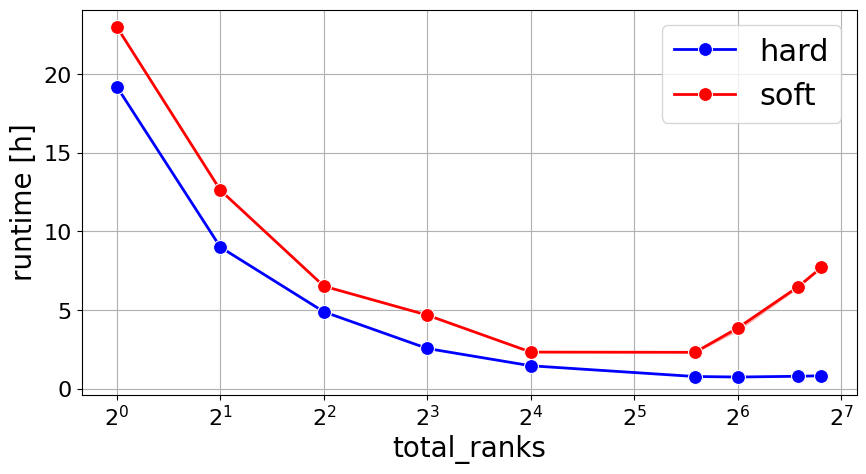

In [17]:
makeplot(runtimes, x="total_ranks", y="runtime [h]",
         outname="strong_scaling_runtime_hard_soft.png", xscale="log",  errorbar=("se",0.9))

In [18]:
avg = runtimes.groupby(['total_ranks', 'Mode']).mean(numeric_only=True).reset_index()

# pivot to have one column per model
pivot = avg.pivot(index='total_ranks', columns='Mode', values='runtime [h]')

# compute speedup factor (soft vs hard)
pivot['speedup_factor'] =  pivot['soft'] / pivot['hard'] 

print(pivot)

Mode              hard       soft  speedup_factor
total_ranks                                      
1            19.200000  23.000000        1.197917
2             9.000000  12.622778        1.402531
4             4.889333   6.520778        1.333674
8             2.556650   4.677500        1.829543
16            1.458067   2.327686        1.596420
48            0.775799   2.313176        2.981671
64            0.742869   3.859389        5.195245
96            0.790222   6.497204        8.221996
112           0.824060   7.714352        9.361399


In [21]:
pivot["speedup_factor"].median()

np.float64(1.8295425654665283)

(0.0, 40.0)

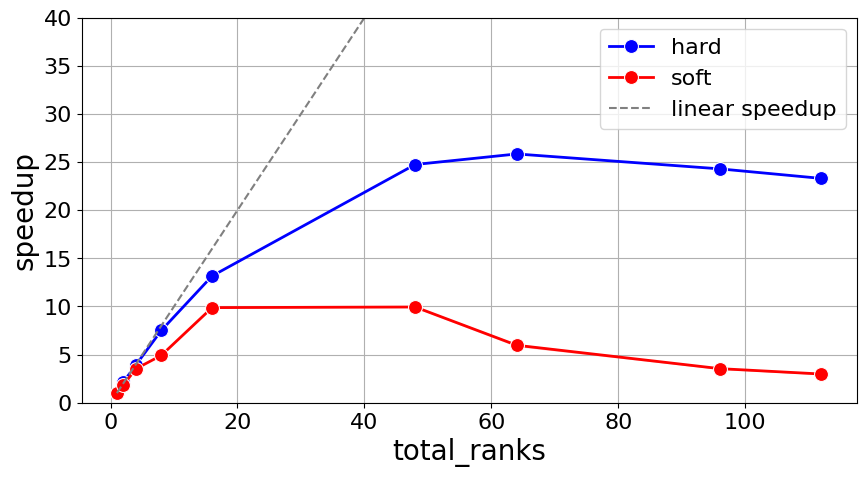

In [19]:
makeplot(runtimes, x="total_ranks", y="speedup",
         outname="strong_scaling_speedup_hard_soft.png", errorbar=("se", 0.3))

# plot y=x
x = np.linspace(1, 112, 100)

plt.gca().plot(x, x, color='gray', linestyle='--', label='linear speedup')

# update legend
plt.gca().legend(fontsize=16)

# set y lim
plt.gca().set_ylim(0, 40)

# set y log

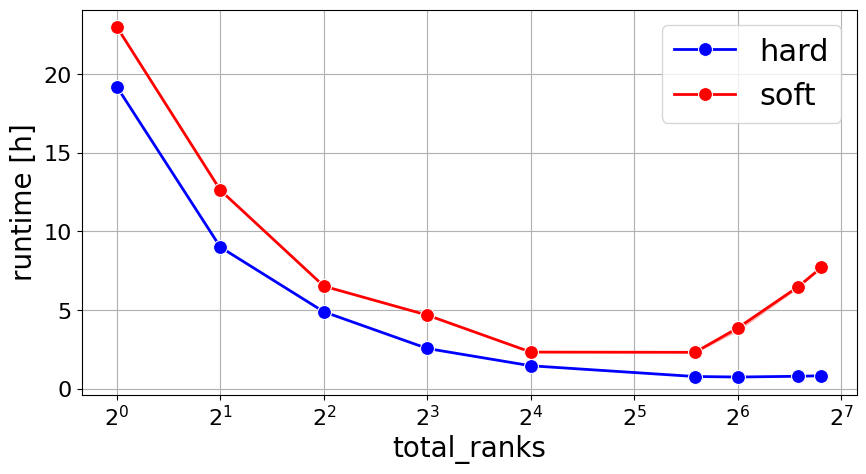

In [ ]:
makeplot(runtimes, x="total_ranks", y="runtime [h]",
         outname="strong_scaling_runtime_hard_soft.png", xscale="log",  errorbar=("se",0.9))

In [26]:
sim_dict.keys()

Index(['iteration', 'simulation_time_s', 'time_since_last_log_s', 'step',
       'num_particles', 'num_constraints', 'colony_radius',
       'recursive_iterations', 'bbpgd_iterations', 'max_overlap', 'residual',
       'memory_usage_mb', 'peak_memory_mb', 'cpu_time_s', 'mpi_comm_time_s',
       'load_imbalance', 'dt_s', 'x', 'y', 'z', 'rank', 'Mode', 'Sensitivity',
       'sim_dir', 'offset'],
      dtype='object')

<Axes: xlabel='total_ranks', ylabel='last_dt_s'>

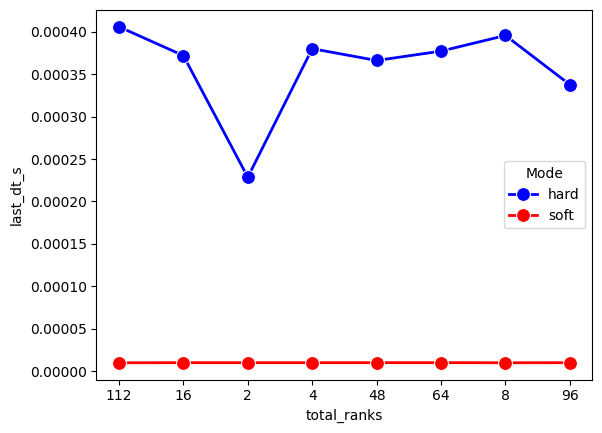

In [40]:
# find last_dt value of all simulations
data=pd.DataFrame()
for _, g in sim_dict.groupby(["Mode", "total_ranks"]):
    last_dts = g["dt_s"].values[-1]
    data = pd.concat([data, pd.DataFrame({
        "Mode": [g["Mode"].values[0]],
        "total_ranks": [g["total_ranks"].values[0]],
        "last_dt_s": [last_dts],
    })], ignore_index=True)


sns.lineplot(data, x="total_ranks", y="last_dt_s", hue="Mode", marker="o",
                lw=2, ms=10, palette=MODE_COLORS)

In [55]:
p=data.pivot(columns='Mode', index='total_ranks', values='last_dt_s')
p["factor"]=p["hard"]/p["soft"]
p["factor"].mean()

np.float64(35.99643833032838)

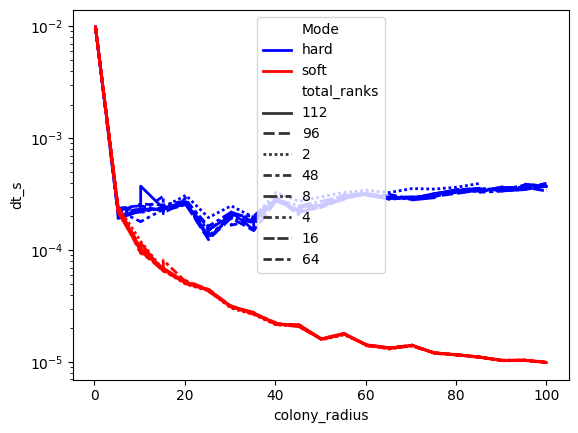

In [46]:
sns.lineplot(sim_dict, x="colony_radius", y="dt_s", hue="Mode",style="total_ranks",
             lw=2, ms=10, palette=MODE_COLORS)
plt.gca().set_yscale("log")

In [38]:
data

,Mode,total_ranks,last_dt_s
0,hard,112,0.000406
1,hard,16,0.000372
2,hard,2,0.000229
3,hard,4,0.000380
4,hard,48,0.000366
5,hard,64,0.000377
6,hard,8,0.000396
7,hard,96,0.000338
8,soft,112,0.000010
9,soft,16,0.000010
